In [1]:
from Train import training
import yaml
import easydict
import matplotlib.pyplot as plt
import math
import random
import os
import torch

import logging
LOG_FORMAT = "%(asctime)s [%(levelname)s] %(message)s"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT, datefmt=DATE_FORMAT)


 ## Task

In [ ]:
logging.getLogger().setLevel(logging.INFO)
with open("./TrainConfig.yaml", "r") as file:
    args = easydict.EasyDict(yaml.safe_load(file))

models = ["pc", "pcsas", "transformer"]

for model in models:
    args.model = model
    for runId in range(1, 5+1, 1):
        args.runId = runId
        record = training(args)

 ## Plotting

2023-05-05 10:36:25 [INFO] tensor([0.1436, 0.1721, 0.1895, 0.2038, 0.2122, 0.2189, 0.2248, 0.2283, 0.2301,
        0.2323, 0.2340, 0.2336, 0.2350, 0.2356, 0.2363, 0.2372, 0.2370, 0.2379,
        0.2378, 0.2378])


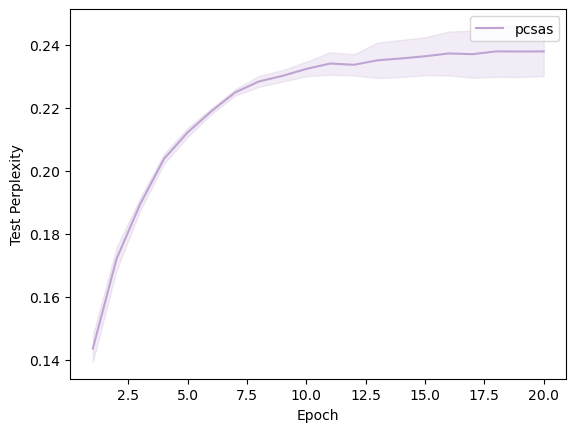

In [6]:
# Plot one line
logging.getLogger().setLevel(logging.INFO)
with open("./TrainConfig.yaml", "r") as file:
    args = easydict.EasyDict(yaml.safe_load(file))

args.model = "pcsas"
testPerplexityList = []
for runId in range(1, 5+1, 1):
    args.runId = runId
    record, args = torch.load("./Data/record/{}-{}-{}-{}-e{}-h{}-{}.pt"
                              .format(args.model, 
                                      args.rnnType, 
                                      args.dataset, 
                                      "glove" if args.preTrained else "none", 
                                      args.embeddingSize, 
                                      args.hiddenSize,
                                      args.runId))
    testPerplexityList.append(record["testAccurancy"])

testPerplexityList = torch.tensor(testPerplexityList)
stdTestPerplexity, meanTestPerplexity = torch.std_mean(testPerplexityList, dim=0)
logging.info(meanTestPerplexity)

plt.plot(range(1, len(meanTestPerplexity)+1), meanTestPerplexity, color="#BFA4D2", label=args.model)
plt.fill_between(range(1, len(meanTestPerplexity)+1), meanTestPerplexity - stdTestPerplexity, meanTestPerplexity + stdTestPerplexity, color="#BFA4D2", alpha=0.2)
# plt.hlines([np.min(meanTestPerplexity)], 0, len(meanTestPerplexity)+1, linestyles="dashed", colors="r", linewidth=0.8)
plt.xlabel("Epoch")
plt.ylabel("Test Perplexity")
plt.legend()
# plt.savefig("./Figures/1.png", dpi=300)
plt.show()
plt.close()


2023-09-08 11:03:18 [INFO] (0, 0)


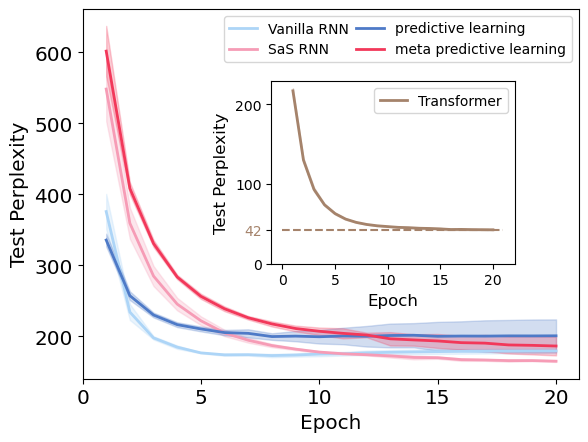

In [3]:
# Plot serveral lines
logging.getLogger().setLevel(logging.INFO)
with open("./TrainConfig1.yaml", "r") as file:
    args = easydict.EasyDict(yaml.safe_load(file))

colorsList = ["#ADD5F7", "#F69CB6", "#4E7AC7", "#F2385A", "#A5836B"]
modelAliasName = ["Vanilla RNN", "SaS RNN", "predictive learning", "meta predictive learning", "Transformer"]
fig, ax = plt.subplots()
for i, model in enumerate(["classic", "sas", "pc", "pcsas", "transformer"]):
    args.model = model
    testPerplexityList = []
    for runId in range(1, 5+1, 1):
        args.runId = runId
        record, args = torch.load("./Data/record/{}-{}-{}-{}-e{}-h{}-{}.pt"
                                .format(args.model, 
                                        args.rnnType, 
                                        args.dataset, 
                                        "glove" if args.preTrained else "none", 
                                        args.embeddingSize, 
                                        args.hiddenSize,
                                        args.runId))
        testPerplexityList.append(record["testPerplexity"])

    testPerplexityList = torch.tensor(testPerplexityList)
    stdTestPerplexity, meanTestPerplexity = torch.std_mean(testPerplexityList, dim=0)
    # stdTestPerplexity *= 3
    if i < 4:
        plt.plot(range(1, len(meanTestPerplexity)+1), meanTestPerplexity, color=colorsList[i], label=modelAliasName[i], linewidth=2.0)
        plt.fill_between(range(1, len(meanTestPerplexity)+1), meanTestPerplexity - stdTestPerplexity, meanTestPerplexity + stdTestPerplexity, color=colorsList[i], alpha=0.25)

    if i==4:
        ax1 = fig.add_axes([0.42, 0.35, 0.38, 0.38])
        bestTestPerplexity = torch.min(torch.mean(testPerplexityList, dim=0)).item()
        ax1.plot(range(1, len(meanTestPerplexity)+1), meanTestPerplexity, color=colorsList[i], label=modelAliasName[i], linewidth=2.0)
        ax1.fill_between(range(1, len(meanTestPerplexity)+1), meanTestPerplexity - stdTestPerplexity, meanTestPerplexity + stdTestPerplexity, color=colorsList[i], alpha=0.25)
        ax1.hlines(bestTestPerplexity, 0, args.numEpoch+1, colors=colorsList[i], linestyles="dashed")
        ax1.set_xlabel("Epoch", fontsize='large')
        ax1.set_ylabel("Test Perplexity", fontsize='large')
        ax1.legend(fontsize='10')
        ax1.set_yticks([0, bestTestPerplexity, 100, 200], [0, math.floor(bestTestPerplexity), 100, 200])
        ax1.get_yticklabels()[1].set_color(colorsList[-1])
        logging.info(ax.get_yticklabels()[1].get_position())

plt.sca(ax)
plt.xlabel("Epoch", fontsize='x-large')
plt.xticks(torch.arange(0, args.numEpoch+1, step=5))
plt.tick_params(labelsize='x-large')
plt.ylabel("Test Perplexity", fontsize='x-large')
plt.legend(fontsize='10', ncol=2, columnspacing=0.5)

# plt.title("Dataset: Penn Treebank", fontsize='x-large')
plt.savefig(f"./Figures/learningCurve-{args.dataset}.pdf")
plt.show()
plt.close()


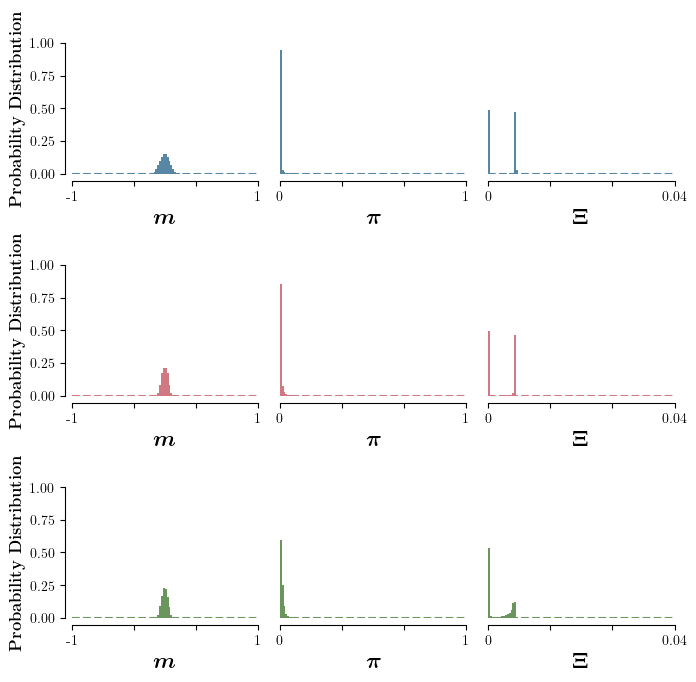

In [8]:
# Plot distribution
import numpy as np


logging.getLogger().setLevel(logging.INFO)
with open("./TrainConfig1.yaml", "r") as file:
    args = easydict.EasyDict(yaml.safe_load(file))

args.model = "pcsas"
model = torch.load("./Data/models/{}-{}-{}-{}-e{}-h{}-{}.pt"
                        .format(args.model, 
                                args.rnnType, 
                                args.dataset, 
                                "glove" if args.preTrained else "none", 
                                args.embeddingSize, 
                                args.hiddenSize,
                                1)) \
                    .cpu()
layers = [model.rnn.inputLayer, model.rnn.hiddenLayer, model.readout]
attrs = ['m', "pi", 'chi']
ranges = [(-1, 1),
          (0, 1),
          (0, 0.04)]
layersName = ['Input Layer', "Reccurent Layer", "Readout Layer"]
attrName = ["$\\boldsymbol{m}$", "$\\boldsymbol{\\pi}$", "$\\boldsymbol{\\Xi}$"]
colors = ["#5787A5", "#D07982", "#6A955D"]
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', family='serif')
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
for layer in layers:
    for i, attr in enumerate(['m', "pi", 'chi']):
        ax = axs[layers.index(layer), i]
        weight = getattr(layer, attr).detach()
        weight = weight.view(-1).numpy()
        # ax.hist(weight, bins=100, normed=True)
        count, bin = np.histogram(weight, bins=100, range=ranges[i], density=True)
        count /= np.sum(count)
        # ax.plot(np.linspace(ranges[i][0], ranges[i][1], 100), count)
        ax.stairs(count, bin, fill=True, color=colors[layers.index(layer)])

        ax.set_xlabel(attrName[i], fontsize=16)
        ax.set_xlim(ranges[i])
        ax.set_xticks(torch.linspace(ranges[i][0], ranges[i][1], 4))
        ax.set_xticklabels((ranges[i][0], "", "", ranges[i][1]))
        ax.set_ylim(0, 1)
        if i == 0:
            ax.set_ylabel("\\textbf{Probability Distribution}", fontsize=12)    
            ax.spines['left'].set_position(('outward', 5))
        else:
            ax.spines["left"].set_visible(False)
            ax.set_yticks([])
        ax.hlines(0, ranges[i][0], ranges[i][1], linestyles="dashed", color=colors[layers.index(layer)])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_position(('outward', 5))

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.7)
plt.savefig(f"./Figures/density-{args.dataset}.pdf")
plt.show()
plt.close()

In [83]:
# Test prediction
logging.getLogger().setLevel(logging.INFO)
with open("./TrainConfig1.yaml", "r") as file:
    args = easydict.EasyDict(yaml.safe_load(file))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filePath = f"./Data/preprocess/{args.dataset}-mf{args.minFrequence}.pt"
rawTrainDataset, rawTestDataset, vocabulary = torch.load(filePath)
# indexs = torch.randint(0, len(rawTestDataset), size=(1, )).item()
indexs = 2397
testSentense = rawTestDataset[indexs]
args.model = "pcsas"

# Compared with the random-choice original text
inputs = torch.tensor(testSentense[:-1], device=device)
targets = torch.tensor(testSentense[1:])
inputsText = [vocabulary.get_itos()[ids] for ids in inputs.to("cpu")]
targetsText = [vocabulary.get_itos()[ids] for ids in targets.to("cpu")]
logging.info(f"Len of sentence: {len(testSentense)}")
logging.info(f"Index: {indexs}")
logging.info("Input: " + " ".join(inputsText))
logging.info("Target: " + " ".join(targetsText))
epochsList = [0, 5, 20]
for e in epochsList:
    model = torch.load("./Data/models/progressing/{}-{}-{}-{}-{}-ep{}.pt"
                            .format(args.model, 
                                    args.rnnType, 
                                    args.dataset, 
                                    "glove" if args.preTrained else "none",
                                    8,
                                    e)).to(device)

    if args.model in ["classic", "sas"]:
        outputs, _ = model(inputs.unsqueeze(1), None)
    else:
        outputs = model(inputs.unsqueeze(1))
    outputs = outputs.squeeze().argmax(dim=1)
    outputsText = [vocabulary.get_itos()[ids] for ids in outputs.to("cpu")]

    logging.info(f"Output in epoch {e}: " + " ".join(outputsText))
    logging.info("Accurancy in epoch {}: {:.2%}".format(e, torch.sum(targets == outputs.cpu()) / targets.size(0)))

2023-08-25 12:04:13 [INFO] Len of sentence: 24
2023-08-25 12:04:13 [INFO] Index: 2397
2023-08-25 12:04:13 [INFO] Input: rated <unk> by moody ' s and <unk> by s&p the issue will be sold through underwriters led by morgan stanley & co
2023-08-25 12:04:13 [INFO] Target: <unk> by moody ' s and <unk> by s&p the issue will be sold through underwriters led by morgan stanley & co <eos>
2023-08-25 12:04:13 [INFO] Output in epoch 0: waxman parliament consist greenwich andy lotus fairly dumped consist cray constituents commanding ordering donaldson exist don lent goodson waterworks hospitals courter lbos spain
2023-08-25 12:04:13 [INFO] Accurancy in epoch 0: 0.00%
2023-08-25 12:04:13 [INFO] Output in epoch 5: triple-a <unk> the ' s <unk> <unk> <unk> the n <unk> is be <unk> by the ' by the stanley & co .
2023-08-25 12:04:13 [INFO] Accurancy in epoch 5: 34.78%
2023-08-25 12:04:13 [INFO] Output in epoch 20: triple-a <unk> the ' s 500-stock <unk> <unk> the n <unk> of be sold by underwriters led by th

In [3]:
# Test accuracy
from Corpus import batchify

logging.getLogger().setLevel(logging.INFO)
with open("./TrainConfig1.yaml", "r") as file:
    args = easydict.EasyDict(yaml.safe_load(file))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
filePath = f"./Data/preprocess/{args.dataset}-mf{args.minFrequence}.pt"
_, rawTestDataset, vocabulary = torch.load(filePath)
testDataset = batchify(rawTestDataset, args.batchSizes)
numTestBatches = testDataset.size(0) // args.sequenceLength
args.model = "pcsas"
epochsList = torch.linspace(0, 20, 21, dtype=torch.int32)
for e in epochsList:
    model = torch.load("./Data/models/progressing/{}-{}-{}-{}-{}-ep{}.pt"
                            .format(args.model, 
                                    args.rnnType, 
                                    args.dataset, 
                                    "glove" if args.preTrained else "none",
                                    8,
                                    e)).to(device)
    
    totalTestLoss = 0.0
    correct = 0
    model.eval()
    for i, sequenceInitialIndex in enumerate(range(0, testDataset.size(0) - 1, args.sequenceLength)):
        currentSequenceLength = min(args.sequenceLength, testDataset.size(0) - 1 - sequenceInitialIndex)
        inputs = testDataset[sequenceInitialIndex:sequenceInitialIndex + currentSequenceLength].to(device)
        targets = testDataset[sequenceInitialIndex+1:sequenceInitialIndex + currentSequenceLength + 1].to(device)
        
        if args.model in ["classic", "sas"]:
            outputs, _ = model(inputs, None)
        else:
            outputs = model(inputs)

        correct += torch.sum(torch.argmax(outputs, dim=1) == targets.reshape(-1)).item()
    
    accurancy = correct / len(testDataset) / args.batchSizes
    logging.info("[Test] Accurancy: {:.2%}".format(accurancy))

    accuracyList = []
    for sentence in rawTestDataset[:100]:
        inputs = torch.tensor(sentence[:-1], device=device)
        targets = torch.tensor(sentence[1:])
        inputsText = [vocabulary.get_itos()[ids] for ids in inputs.to("cpu")]
        targetsText = [vocabulary.get_itos()[ids] for ids in targets.to("cpu")]

        if args.model in ["classic", "sas"]:
            outputs, _ = model(inputs.unsqueeze(1), None)
        else:
            outputs = model(inputs.unsqueeze(1))
        outputs = outputs.squeeze().argmax(dim=1)
        outputsText = [vocabulary.get_itos()[ids] for ids in outputs.to("cpu")]

        accuracyList.append((torch.sum(targets == outputs.cpu()) / targets.size(0)).item())
        
    accuracyList = torch.tensor(accuracyList)
    stdAccuracy, meanAccuracy = torch.std_mean(accuracyList)
    logging.info(f"[Test] mean accuracy: {meanAccuracy}, std accuracy: {stdAccuracy}")

    

2023-08-25 14:00:06 [INFO] [Test] Accurancy: 0.01%
2023-08-25 14:00:10 [INFO] [Test] mean accuracy: 0.0005000000237487257, std accuracy: 0.004999999888241291
2023-08-25 14:00:11 [INFO] [Test] Accurancy: 13.61%
2023-08-25 14:00:14 [INFO] [Test] mean accuracy: 0.13196450471878052, std accuracy: 0.09087289869785309
2023-08-25 14:00:15 [INFO] [Test] Accurancy: 16.08%
2023-08-25 14:00:19 [INFO] [Test] mean accuracy: 0.16291074454784393, std accuracy: 0.09977036714553833
2023-08-25 14:00:19 [INFO] [Test] Accurancy: 18.08%
2023-08-25 14:00:23 [INFO] [Test] mean accuracy: 0.1752200722694397, std accuracy: 0.1088053435087204
2023-08-25 14:00:23 [INFO] [Test] Accurancy: 19.58%
2023-08-25 14:00:27 [INFO] [Test] mean accuracy: 0.19503198564052582, std accuracy: 0.1061985045671463
2023-08-25 14:00:27 [INFO] [Test] Accurancy: 21.01%
2023-08-25 14:00:31 [INFO] [Test] mean accuracy: 0.21286620199680328, std accuracy: 0.10626741498708725
2023-08-25 14:00:32 [INFO] [Test] Accurancy: 21.63%
2023-08-25 14